In [1]:
%load_ext autoreload
%autoreload 1

%aimport src.utils.tardisml_utils

In [2]:
%reload_ext autoreload

In [5]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl

from src.data_preparation import mdl_dataset_prep as dataset_prep

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca
import src.visualization.visualize_pca as visualize_pca
# import src.visualization.visualize_error as visualize_error
from src.visualization import mdl_introspect

from src.data_preparation.blocking_time_series_split import BlockingTimeSeriesSplit 
from src.data_preparation import mdl_dataset_prep
from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

In [6]:
# Date to plot in example
idate = 100
# Path to config file
file_config = '../config/data_proc_full.yaml'
# Path to template file
file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template),Loader=yaml.FullLoader)
load_config.update_config(file_config, verbose=True)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir, _ = load_config.load_filename(file_config, verbose=True)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)
ml_model, nseq, params = load_config.load_ml_params(file_config)

PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated (pca_dir): ../config/data_proc_full.yaml
Config file updated: ../config/data_proc_full.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/cnn_Npred22_7F_rw29d_N8844_H1333_Hn0000_sithick_noname_221212-144448
Folder created

Config file updated.


In [7]:
# copy config file to results
!cp {file_config} {rootdir+res_dir}

- mslprs: Mean sea-level pressure
- airtmp: Air temperature

- --

### Loading the whole dataset

- --

In [8]:
# Path to config file
file_config = '../config/data_proc_full.yaml'

In [9]:
# Xf, PCs_f, Xe, PCs_e, PCs_co, PCs_fo, chrono = load_data.load_dataset(file_config)

In [10]:
from importlib import reload
reload(load_data)

<module 'src.data_preparation.load_data' from '/cluster/home/leoede/tardis/tardis-ml/src/data_preparation/load_data.py'>

In [ ]:
Xf, PCs_f, Xe, PCs_e, PCs_co, PCs_fo, dsCo, dsFo, chrono = load_data.load_dataset_PCA(file_config, return_raw=True, freerun=True)

Retrieve siconc
Retrieve sisnthick
Retrieve vxsi
Retrieve vysi
Retrieve zos
Loading forcing values...
Loading pca...
Apply land/ocean mask...
Retrieve PCs and EOFs


In [ ]:
data = (Xf, PCs_f, Xe, PCs_e, PCs_co, PCs_fo, dsCo, dsFo, chrono)

- --

### Preparing the dataset

- --

In [ ]:
history_param = {}

history_param['bias'] = {}
history_param['noass'] = {}
history_param['forcing'] = {}
history_param['covar'] = {}

history_param['bias']['H'] = [1]
history_param['bias']['H_neg'] = 0

history_param['noass']['H'] = [1]
history_param['noass']['H_neg'] = 0

history_param['forcing']['names'] = forcing_fields
history_param['forcing']['to_explore'] = ['2T']
history_param['forcing']['must_be'] = [1]
history_param['forcing']['interval'] = 7
history_param['forcing']['nexplo'] = 4

history_param['covar']['names'] = covar_fields
history_param['covar']['to_explore'] = ['sisnthick']
history_param['covar']['must_be'] = [1]
history_param['covar']['interval'] = 7
history_param['covar']['nexplo'] = 4

In [ ]:
from importlib import reload
reload(mdl_dataset_prep)

In [ ]:
X, y, chrono, inputs = mdl_dataset_prep.data_to_dataset(data, history_param, invert_t=True)

----------

In [14]:
np.where(np.array(inputs)=='2T t+0 PC0')

(array([48]),)

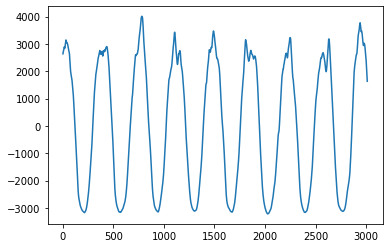

In [15]:
plt.plot(X[:,48])

#### Split the dataset

In [16]:
ntrain, nval, ntest = mdl_dataset_prep.dataset_split(X.shape[0])

In [17]:
ntrain, nval, ntest

(2410, 0, 603)

In [18]:
print('ML is given the following inputs:')
inputs

ML is given the following inputs:


['Xe t+1 PC0',
 'Xe t+1 PC1',
 'Xe t+1 PC2',
 'Xe t+1 PC3',
 'Xe t+1 PC4',
 'Xe t+1 PC5',
 'Xe t+1 PC6',
 'Xe t+1 PC7',
 'Xe t+2 PC0',
 'Xe t+2 PC1',
 'Xe t+2 PC2',
 'Xe t+2 PC3',
 'Xe t+2 PC4',
 'Xe t+2 PC5',
 'Xe t+2 PC6',
 'Xe t+2 PC7',
 'SITf t+0 PC0',
 'SITf t+0 PC1',
 'SITf t+0 PC2',
 'SITf t+0 PC3',
 'SITf t+0 PC4',
 'SITf t+0 PC5',
 'SITf t+0 PC6',
 'SITf t+0 PC7',
 'SITf t+1 PC0',
 'SITf t+1 PC1',
 'SITf t+1 PC2',
 'SITf t+1 PC3',
 'SITf t+1 PC4',
 'SITf t+1 PC5',
 'SITf t+1 PC6',
 'SITf t+1 PC7',
 '10U t+0 PC0',
 '10U t+0 PC1',
 '10U t+0 PC2',
 '10U t+0 PC3',
 '10U t+1 PC0',
 '10U t+1 PC1',
 '10U t+1 PC2',
 '10U t+1 PC3',
 '10V t+0 PC0',
 '10V t+0 PC1',
 '10V t+0 PC2',
 '10V t+0 PC3',
 '10V t+1 PC0',
 '10V t+1 PC1',
 '10V t+1 PC2',
 '10V t+1 PC3',
 '2T t+0 PC0',
 '2T t+0 PC1',
 '2T t+0 PC2',
 '2T t+0 PC3',
 '2T t+1 PC0',
 '2T t+1 PC1',
 '2T t+1 PC2',
 '2T t+1 PC3',
 '2T t+8 PC0',
 '2T t+8 PC1',
 '2T t+8 PC2',
 '2T t+8 PC3',
 '2T t+15 PC0',
 '2T t+15 PC1',
 '2T t+15 PC2',
 '2T

----

## A first simple model

### Initialize variables and model parameters

#### Input variables

In [18]:
# additional parameters for the model

# cross validation
n_iter_bay = 100
bayesian_search = False
return_train_score = False
introspect = False

# input variables
input_dico = ''  # default: all variables

# load input_dico, to set selection directly
# ! need same X !
# idir = '/nird/projects/nird/NS2993K/Leo/results/'

# idir = '/cluster/work/users/leoede/Leo/results/grdbst_Npred22_2F_rw21d_N4444_H1333_Hn0000_hice00_artc_220816-205402/ml/'
# ifile = 'input_dico_01.npy'

idir = '/nird/projects/nird/NS2993K/Leo/results/grdbst_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc/ml/'
ifile = 'input_dico.npy'
# dicoback = np.load(f'{idir}{ifile}', allow_pickle=True)
# input_dico = dicoback[None][0]

# load model
# model_to_load = ''


In [19]:
input_dd = mdl_input_dico.InputDico()
input_dd.init_true(4, inputs)
# input_dd.keep_only_best(ml_model)

In [20]:
# input_dd.switch_to_true(folabels)

In [21]:
# input_dd.switch_to_true(hyplabels)

In [22]:
# input_dd.switch_to_false(['Xe t+1 PC0', 'la', 'Xe t+2 PC2', 'Xtp'])
# input_dd.switch_to_true(['airtmp t+3 PC0', 'airtmp t+6 PC0','airtmp t+9 PC0','airtmp t+12 PC0'])

----

----

#### GridSearch params / Model Params

In [23]:
param = mdl_params.Params(ml_model, 4)

# param.get_search(booster='dart')
param.optimize(random_state=0, booster='dart')

### Initialize model

In [14]:
from src.modelling import model_cnn
from keras.regularizers import L1L2

2022-10-21 11:18:56.003381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 11:18:56.003442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
# splitting the dataset
ntrain, nval, ntest = mdl_dataset_prep.dataset_split(X.shape[0])



print('Formatting the dataset...')

H = [0,7,14,21,28, 35, 42, 49, 56, 63, 70, 77]
ds = model_cnn.build_dataset_1pt(X, y, chrono, train_p=.8, times=H) # H

Formatting the dataset...


In [16]:
# Variables to keep for CNN
most_imp = ['SITf t+0', 'sisnthick t+0', '2T t+0', 'MSL t+0', 'TP t+0']
indexes = []
for mi in most_imp:
    for idx, lb in enumerate(inputs):
        if mi in lb:
            indexes.append(idx)
            

In [17]:
var_name = np.array(inputs)[indexes]

# select only variables to keep
ds[0]['Xtrain'] = ds[0]['Xtrain'][:,:, indexes]
ds[0]['Xtest'] = ds[0]['Xtest'][:,:, indexes]

In [18]:
# dataset final
fds = {}
fds[0] = ds[0].copy()

In [19]:
regularizers = [L1L2(l1=0.01, l2=0), L1L2(l1=0, l2=0.01), L1L2(l1=0.1, l2=0.1)]

In [37]:
fds[0]['ytrain'].shape

(2349, 8)

In [20]:
from importlib import reload
reload(model_cnn);

Working on PC1...


2022-10-21 11:20:31.588968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-21 11:20:31.605445: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-21 11:20:31.611223: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-2.fram.sigma2.no): /proc/driver/nvidia/version does not exist
2022-10-21 11:20:31.632801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 24)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 12, 24)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 12, 24)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 12, 256)      18688       ['input_1[0][0]']                
                                                                                              

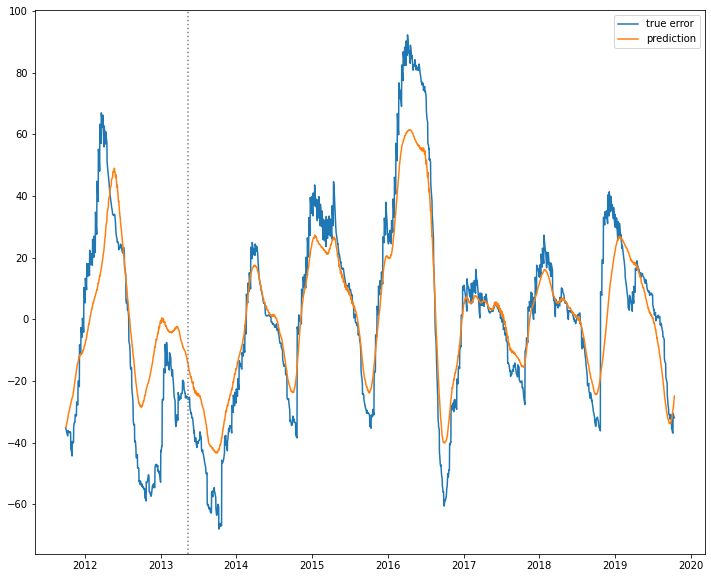

loss : 610.7942504882812
r_square : 0.5586609840393066
root_mean_squared_error : 23.424488067626953


In [21]:
ipca = 0
print(f'Working on PC{ipca}...')
ds[0]['ytrain'] = fds[0]['ytrain'][:,ipca]
ds[0]['ytest'] = fds[0]['ytest'][:,ipca]

n_output = ds[0]['ytrain'].shape[0]
model_mh_reg = model_cnn.CNN_multihead_model(ds[0]['Xtrain'].shape[1], ds[0]['Xtrain'].shape[2], n_output=1, reg=regularizers[2], rootdir=rootdir)
suffixe = f'_PCA{ipca}'
model_cnn.fit_cnn_mh(model_mh_reg, ds, epochs=100, batch_size=128, print_arch_model=True, print_history=True, suffix=suffixe)

Working on PC0...
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 12, 256)      18688       ['input_28[0][0]']               
                                                                          

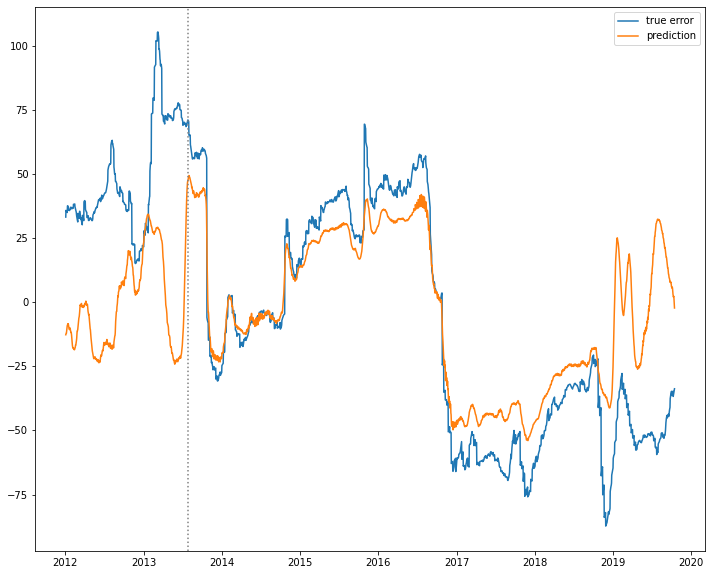

loss : 3171.701416015625
r_square : -5.813901901245117
root_mean_squared_error : 56.089576721191406
Working on PC1...
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 12, 256)      18688       ['input

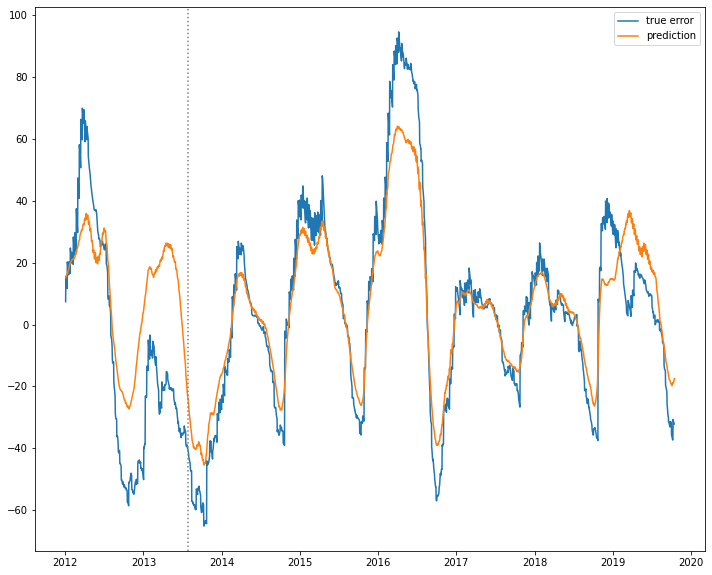

loss : 893.48583984375
r_square : 0.3161763548851013
root_mean_squared_error : 29.603595733642578
Working on PC2...
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 12, 256)      18688       ['input_3

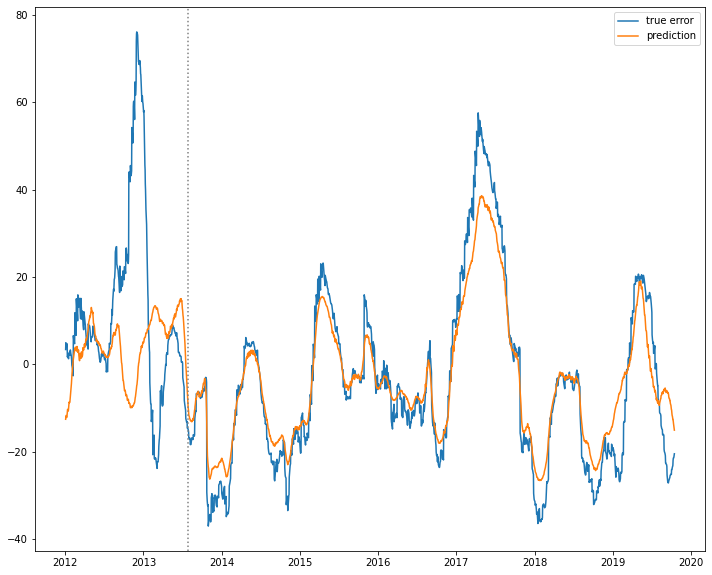

loss : 738.6055297851562
r_square : -0.5320031642913818
root_mean_squared_error : 26.96776008605957
Working on PC3...
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 12, 256)      18688       ['input

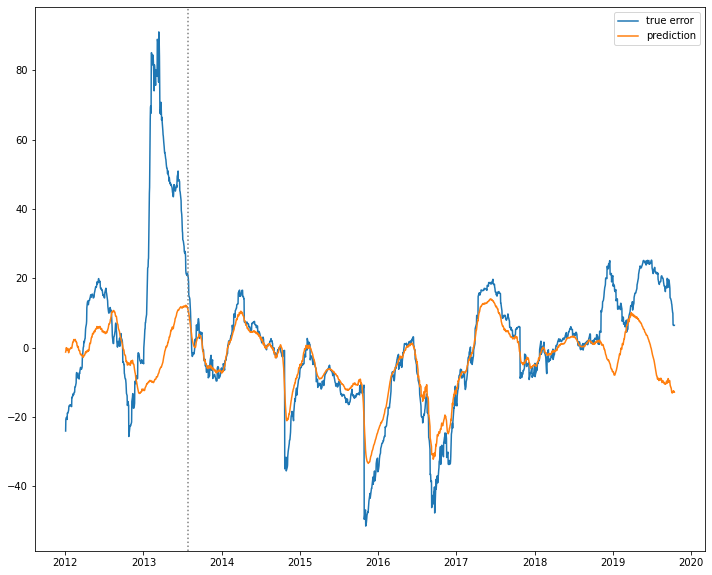

loss : 1230.96240234375
r_square : -0.4173954725265503
root_mean_squared_error : 34.986751556396484
Working on PC4...
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_41 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 conv1d_39 (Conv1D)             (None, 12, 256)      18688       ['input

                                                                                                  
 flatten_44 (Flatten)           (None, 1536)         0           ['max_pooling1d_44[0][0]']       
                                                                                                  
 concatenate_14 (Concatenate)   (None, 4608)         0           ['flatten_42[0][0]',             
                                                                  'flatten_43[0][0]',             
                                                                  'flatten_44[0][0]']             
                                                                                                  
 dense_28 (Dense)               (None, 100)          460900      ['concatenate_14[0][0]']         
                                                                                                  
 dense_29 (Dense)               (None, 1)            101         ['dense_28[0][0]']               
          

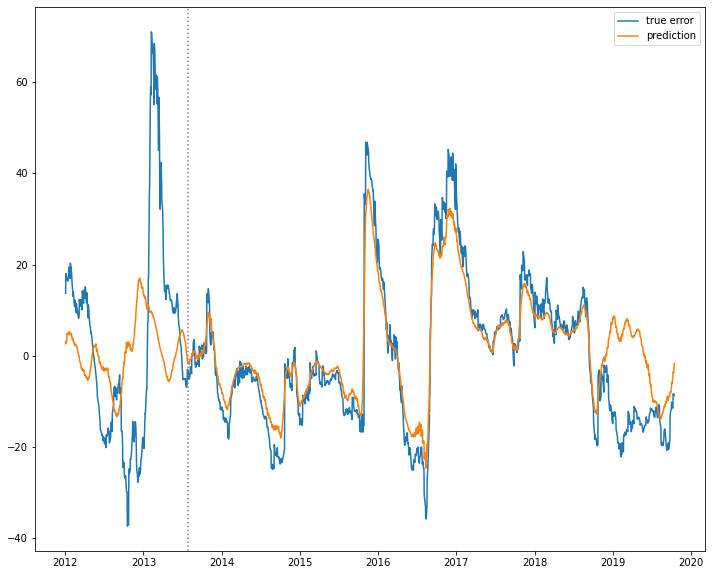

loss : 565.62353515625
r_square : -0.023656845092773438
root_mean_squared_error : 23.60234260559082
Working on PC6...
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_47 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 conv1d_45 (Conv1D)             (None, 12, 256)      18688       ['input

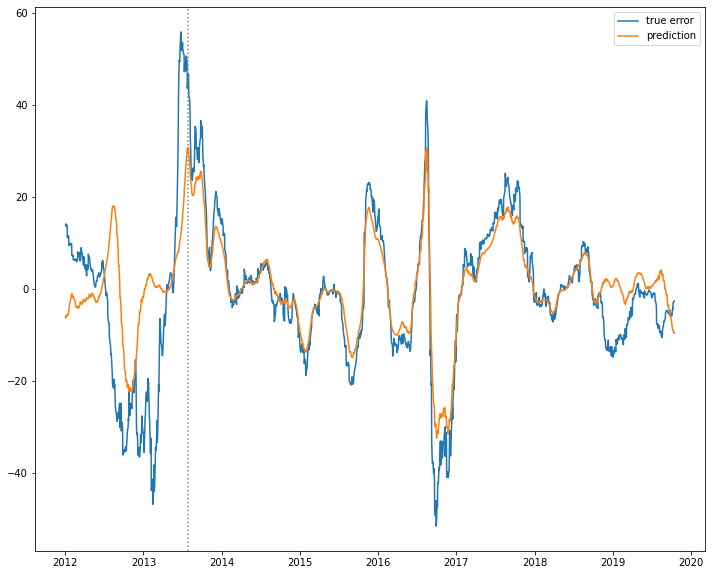

loss : 463.6203308105469
r_square : 0.15671193599700928
root_mean_squared_error : 21.345970153808594
Working on PC7...
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 input_51 (InputLayer)          [(None, 12, 24)]     0           []                               
                                                                                                  
 conv1d_48 (Conv1D)             (None, 12, 256)      18688       ['inpu

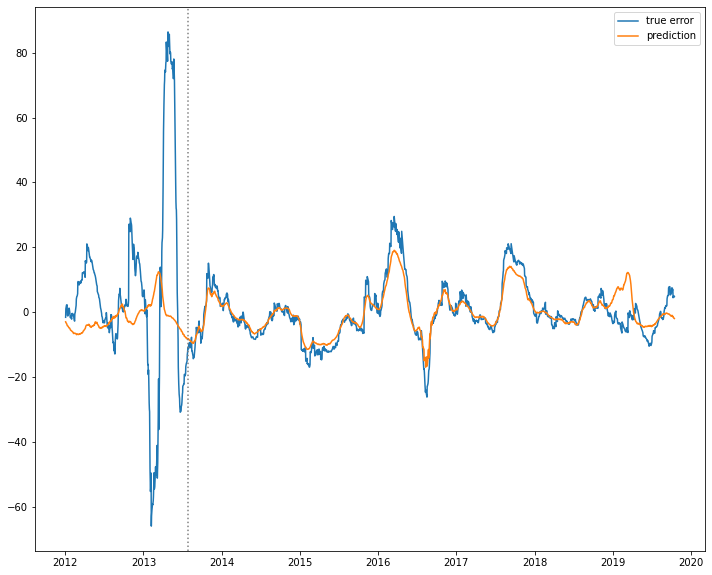

loss : 1023.1392822265625
r_square : -0.1484203338623047
root_mean_squared_error : 31.916501998901367


In [52]:
# for each PCA separatly


for ipca in range(y.shape[1]):
    print(f'Working on PC{ipca}...')
    ds[0]['ytrain'] = fds[0]['ytrain'][:,ipca]
    ds[0]['ytest'] = fds[0]['ytest'][:,ipca]

    n_output = ds[0]['ytrain'].shape[0]
    model_mh_reg = model_cnn.CNN_multihead_model(ds[0]['Xtrain'].shape[1], ds[0]['Xtrain'].shape[2], n_output=1, reg=regularizers[2], rootdir=rootdir)
    suffixe = f'_PCA{ipca}'
    model_cnn.fit_cnn_mh(model_mh_reg, ds, epochs=100, batch_size=4, print_arch_model=True, print_history=True, suffix=suffixe)

In [23]:
import shap

In [24]:
# init the JS visualization code
shap.initjs()

In [25]:
# DEEP EXPLAINER - works with 3D dataset

explainer = shap.DeepExplainer(model_mh_reg, [ds[0]['Xtrain']]*3)
shap_values = explainer.shap_values([ds[0]['Xtest']]*3)

# shap.force_plot(explainer.expected_value[0], shap_value[0], ds[0]['Xtest'], link='logit')


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [47]:
ds[0]['Xtrain'].shape

(2348, 12, 24)

In [48]:
ds[0]['Xtest'].shape

(588, 12, 24)

In [46]:
np.vstack((ds[0]['Xtest'], ds[0]['Xtrain'])).shape

(2936, 12, 24)

In [52]:
full_X = np.vstack((ds[0]['Xtest'], ds[0]['Xtrain']))
shap_values = explainer.shap_values([full_X]*3)

In [26]:
ds[0]['Xtest'].shape

(588, 12, 24)

In [27]:
len(shap_values[0][0])

588

In [28]:
shap_values[0][:][0].shape

(588, 12, 24)

In [29]:
# mean shap values over History
mean_shap = np.mean(shap_values[0][:][0],axis=(1))

In [30]:
mean_shap

array([[-0.24205022, -0.01020642, -0.02355669, ..., -0.00860012,
         0.00634592,  0.02269738],
       [-0.24045205, -0.01039787, -0.02276904, ..., -0.00890381,
         0.00668941,  0.02260225],
       [-0.23798499, -0.00965162, -0.0222832 , ..., -0.00801681,
         0.00762537,  0.02111017],
       ...,
       [ 0.16189723, -0.03460631,  0.08743993, ...,  0.03747441,
        -0.01288193,  0.01088192],
       [ 0.16260915, -0.0345414 ,  0.08793997, ...,  0.03378867,
        -0.01399861,  0.01122402],
       [ 0.16398518, -0.03388185,  0.08826073, ...,  0.03230142,
        -0.01428743,  0.01188653]])

In [31]:
# shap values for History = 0
reshape_shap = (shap_values[0][:][0])[:,0]

In [32]:
shap_values[0][0][0][0]

array([-0.38961805, -0.01568591, -0.03685031,  0.08313262,  0.05654301,
        0.05077455, -0.0158074 , -0.1381124 , -0.09628838,  0.03455108,
       -0.00787336,  0.00049179, -0.00155855, -0.00756773,  0.00260112,
       -0.09317825, -0.03460789, -0.01868713, -0.04271206,  0.0057836 ,
       -0.06341874, -0.02507129,  0.01374712,  0.00527064])

In [33]:
var_name

array(['SITf t+0 PC0', 'SITf t+0 PC1', 'SITf t+0 PC2', 'SITf t+0 PC3',
       'SITf t+0 PC4', 'SITf t+0 PC5', 'SITf t+0 PC6', 'SITf t+0 PC7',
       'sisnthick t+0 PC0', 'sisnthick t+0 PC1', 'sisnthick t+0 PC2',
       'sisnthick t+0 PC3', '2T t+0 PC0', '2T t+0 PC1', '2T t+0 PC2',
       '2T t+0 PC3', 'MSL t+0 PC0', 'MSL t+0 PC1', 'MSL t+0 PC2',
       'MSL t+0 PC3', 'TP t+0 PC0', 'TP t+0 PC1', 'TP t+0 PC2',
       'TP t+0 PC3'], dtype='<U18')

In [34]:
explainer.expected_value.numpy()[0]

1.9561884

In [55]:
shap.force_plot(explainer.expected_value.numpy()[0], shap_values[0][0][0][0], var_name)

In [56]:
shap.force_plot(explainer.expected_value.numpy()[0], mean_shap, var_name)

In [37]:
var_name

array(['SITf t+0 PC0', 'SITf t+0 PC1', 'SITf t+0 PC2', 'SITf t+0 PC3',
       'SITf t+0 PC4', 'SITf t+0 PC5', 'SITf t+0 PC6', 'SITf t+0 PC7',
       'sisnthick t+0 PC0', 'sisnthick t+0 PC1', 'sisnthick t+0 PC2',
       'sisnthick t+0 PC3', '2T t+0 PC0', '2T t+0 PC1', '2T t+0 PC2',
       '2T t+0 PC3', 'MSL t+0 PC0', 'MSL t+0 PC1', 'MSL t+0 PC2',
       'MSL t+0 PC3', 'TP t+0 PC0', 'TP t+0 PC1', 'TP t+0 PC2',
       'TP t+0 PC3'], dtype='<U18')

In [57]:
# shap.force_plot(explainer.expected_value.numpy()[0], reshape_shap, var_name)
shap.force_plot(explainer.expected_value.numpy()[0], (shap_values[0][:][0])[:,11], var_name)

----

----

In [272]:
# add noise to input data to see how outputs change

def add_noise(dataset):
    
    Xtrain = dataset[0]['Xtrain'].copy()
    dataset[0]['Xtrain'] = Xtrain + np.random.normal(0, np.std(Xtrain) / 5, Xtrain.shape)

    
    Xtest = dataset[0]['Xtest'].copy()
    dataset[0]['Xtest'] = Xtest + np.random.normal(0, np.std(Xtest) / 5, Xtest.shape)
    
    return dataset
    
    

44/44 [==============================] - 0s 2ms/step


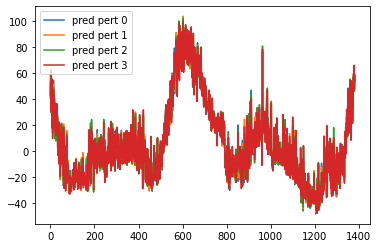

In [274]:
# seemed like a good idea but nothing fancy about the results
# more noise in the dataset = more noise in the prediction

ntest = 4

for i in range(ntest):
    ds2 = add_noise(ds.copy())
    yp = pred_cnn_mh(model_mh, ds2)
    plt.plot(yp, label=f'pred pert {i}')
    
    
plt.legend()

----

### Save best estimator ML for later use

In [ ]:
m1.save_best_est()

# save input_dico as well

In [ ]:
m1.save_ypred()

-----